# <center><span style='color:green'> Household Electricity Consumption </span></center>

## Problem Statement

* Predict the household electricity consumption
* Regression problem

## 1 <span style='color:red'>|</span> Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#for modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score , r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor , RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

#database
import pymongo

#save the model
import pickle

#to read data
import zipfile

## 2 <span style='color:red'>|</span> Load Dataset

In [2]:
zip_file_path = "cosumption_data.zip"
file_name = "household_power_consumption.txt"

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    file_list = zip_file.namelist()
    for file in file_list:
        if file == file_name:
            with zip_file.open(file_name) as csv_file:
                df = pd.read_csv(csv_file, delimiter=';')

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.shape

(2075259, 9)

* Taking a sample of 60000 as data is too large 

In [5]:
df_sample = df.sample(60000)
df_sample.shape

(60000, 9)

## 3 <span style='color:red'>|</span> Exploratory Data Analysis

In [6]:
df_sample.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [7]:
df_sample.drop(['Date','Time'], axis=1, inplace=True)

In [8]:
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
909168,0.250,0.084,244.520,1.200,0.000,0.000,1.0
1215530,3.334,0.368,238.450,14.200,0.000,0.000,1.0
1284547,0.416,0.180,227.850,2.000,0.000,1.000,1.0
1980989,1.978,0.260,238.180,8.400,1.000,0.000,28.0
177257,0.418,0.238,241.090,2.000,0.000,0.000,0.0


In [9]:
df_sample.sample(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
800950,2.690,0.218,235.480,11.400,2.000,0.000,17.0
1602249,1.406,0.000,243.660,5.800,0.000,0.000,19.0
1942877,0.284,0.106,243.520,1.200,0.000,0.000,0.0
1557119,0.400,0.218,240.670,1.800,0.000,0.000,1.0
263384,0.746,0.354,240.680,3.400,0.000,2.000,0.0
618852,4.972,0.374,235.410,21.200,0.000,36.000,18.0
2037040,0.372,0.136,245.06,1.6,0.0,0.0,0.0
1936742,?,?,?,?,?,?,NaN
630070,0.222,0.000,241.780,0.800,0.000,0.000,0.0
1391088,2.006,0.260,240.090,8.400,0.000,0.000,30.0


In [10]:
df_sample.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

#### 3.1 <span style='color:red'>|</span> Check any special character and handle them 

In [11]:
character_check = any(not value.isnumeric() for value in df_sample['Global_active_power'])
character_check

True

In [12]:
character = [value for value in df_sample['Global_active_power'] if not str(value).replace('.','',1).isnumeric()]
set(character)

{'?'}

In [13]:
#Check character in dataframe
special_char = df_sample[df_sample['Global_active_power']=='?']
special_char

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
191547,?,?,?,?,?,?,NaN
1619467,?,?,?,?,?,?,NaN
1935665,?,?,?,?,?,?,NaN
1937009,?,?,?,?,?,?,NaN
193493,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...
1618365,?,?,?,?,?,?,NaN
1935421,?,?,?,?,?,?,NaN
1398031,?,?,?,?,?,?,NaN
1398358,?,?,?,?,?,?,NaN


* 737/60000 rows and 7/7 columns has special character in it

In [14]:
(737/60000)*100

1.2283333333333333

In [15]:
#drop the data having special character
print("Data before removal of special character :", df_sample.shape)
df_sample.drop(special_char.index, axis=0, inplace=True)
print("Data after removal of special character :", df_sample.shape)

Data before removal of special character : (60000, 7)
Data after removal of special character : (59210, 7)


#### 3.2 <span style='color:red'>|</span> Check duplicates

In [16]:
df_sample.duplicated().sum()

259

* 265 duplicates record found

In [17]:
print("Data with duplicate records :", df_sample.shape)
df_sample.drop_duplicates(inplace=True)
print("Data withour duplicate records :", df_sample.shape)

Data with duplicate records : (59210, 7)
Data withour duplicate records : (58951, 7)


#### 3.3 <span style='color:red'>|</span> Check null values

In [18]:
df_sample.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

* No null values in dataset

#### 3.4 <span style='color:red'>|</span> Convert dtype of columns

In [19]:
df_sample = df_sample.astype(float)

In [20]:
df_sample.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

#### 3.5 <span style='color:red'>|</span> Combining Features

In [21]:
df_sample['meter'] = df_sample['Sub_metering_1'] + df_sample['Sub_metering_2'] + df_sample['Sub_metering_2']

In [22]:
df_sample.drop(['Sub_metering_1','Sub_metering_2','Sub_metering_3'], axis=1, inplace=True)

In [23]:
df_sample.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'meter'],
      dtype='object')

In [24]:
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,meter
909168,0.250,0.084,244.52,1.2,0.0
1215530,3.334,0.368,238.45,14.2,0.0
1284547,0.416,0.180,227.85,2.0,2.0
1980989,1.978,0.260,238.18,8.4,1.0
177257,0.418,0.238,241.09,2.0,0.0


In [25]:
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,58951.0,1.091083,1.055131,0.078,0.310,0.604,1.524,9.718
Global_reactive_power,58951.0,0.124629,0.113125,0.000,0.048,0.102,0.194,1.080
Voltage,58951.0,240.831017,3.252322,224.540,238.980,241.020,242.870,253.550
Global_intensity,58951.0,4.626093,4.435599,0.200,1.400,2.600,6.400,41.800
meter,58951.0,3.741633,13.462485,0.000,0.000,0.000,2.000,183.000


#### 3.6 <span style='color:red'>|</span> Data Distribution

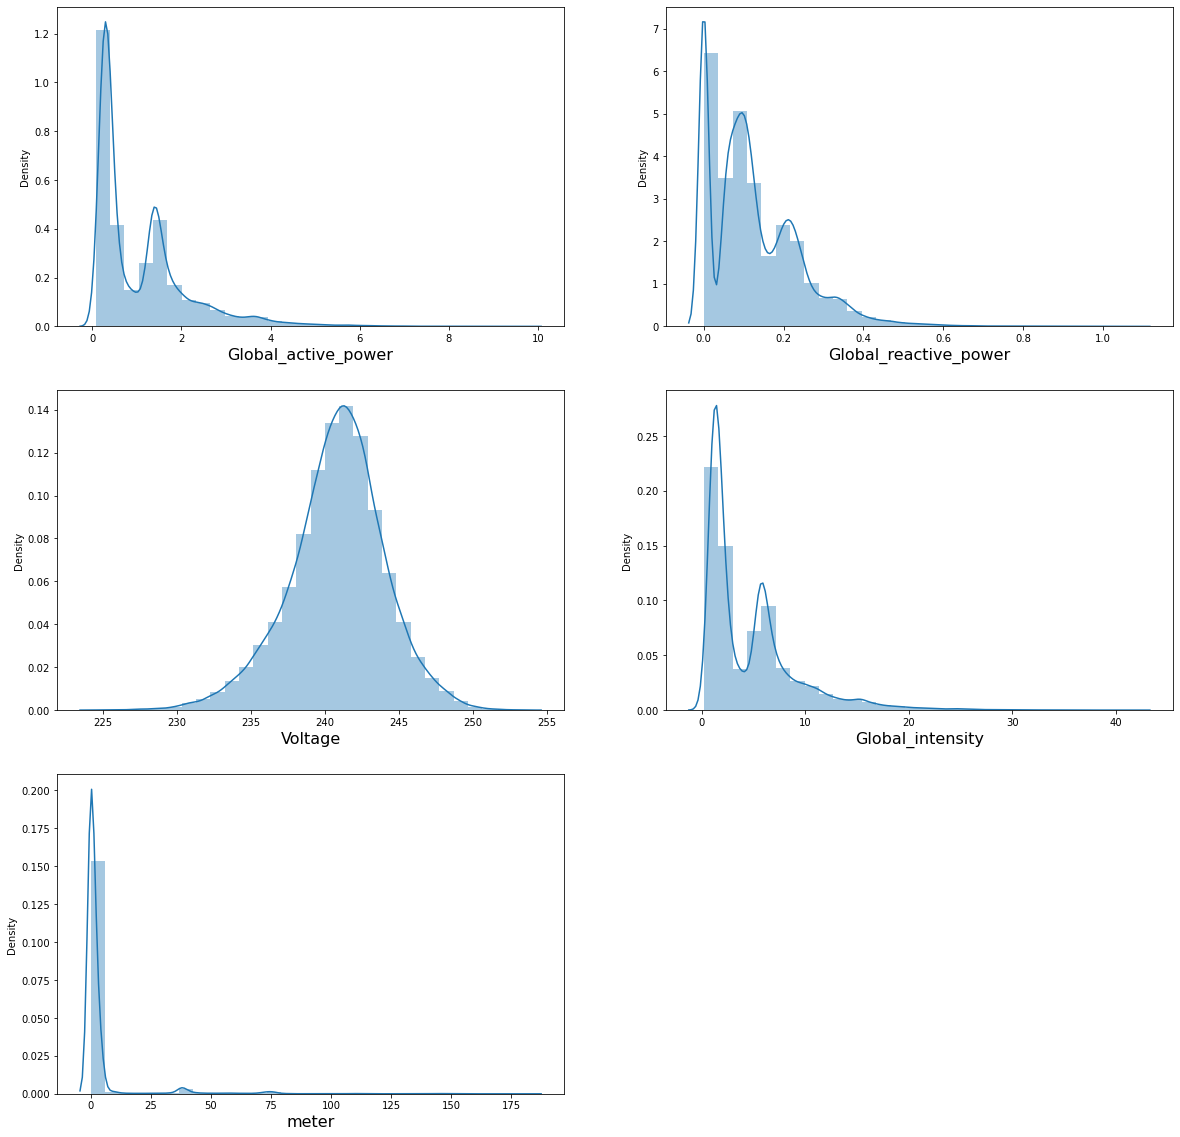

In [26]:
#Data Distribution in each column
plt.figure(figsize=(20,20), facecolor='white')
plotnum =1

for col in df_sample.columns:
    if plotnum <= 5:
        ax = plt.subplot(3,2,plotnum)
        sns.distplot(df_sample[col], bins=30)
        plt.xlabel(col, fontsize=16)
    plotnum += 1
plt.show()

#### 3.7 <span style='color:red'>|</span> Check & Handle outliers

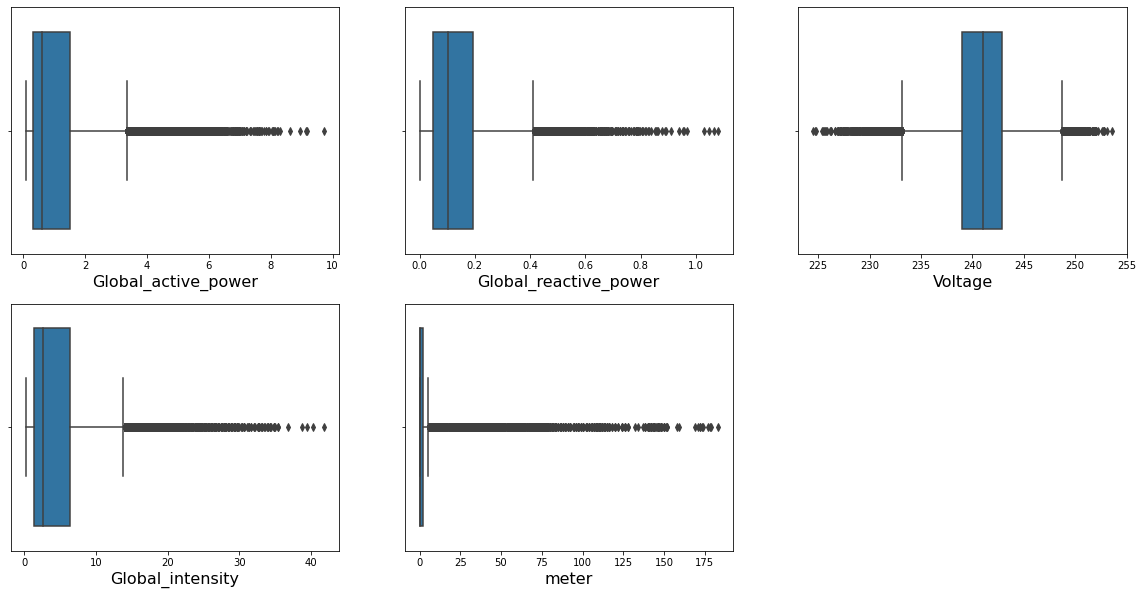

In [27]:
plt.figure(figsize=(20,10))
plotnum = 1

for col in df_sample.columns:
    if plotnum <= 5:
        ax = plt.subplot(2,3,plotnum)
        sns.boxplot(df_sample[col])
        plt.xlabel(col, fontsize=16)
    plotnum += 1
plt.show()

In [28]:
#Handling Outlier

df1 = df_sample.copy()

for col in df1.columns:
    iqr = df1[col].quantile(0.75) - df1[col].quantile(0.25)
    lower_limit = df1[col].quantile(0.25) - (1.5*iqr)
    upper_limit = df1[col].quantile(0.75) + (1.5*iqr)
    
    df1[col] = np.where(df1[col]>upper_limit,upper_limit,np.where(df1[col]<lower_limit,lower_limit,df1[col]))

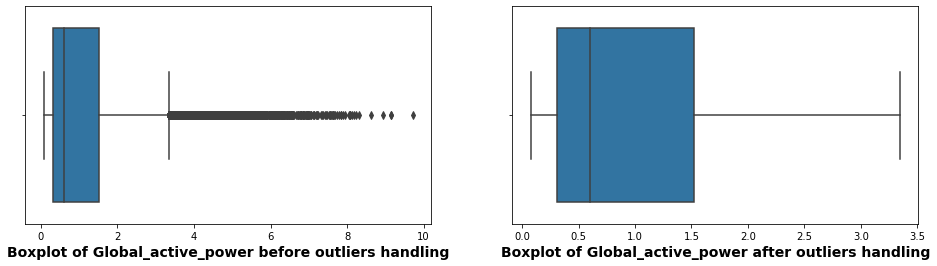

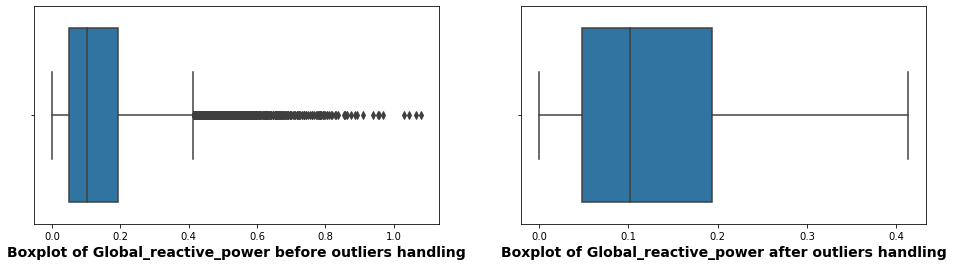

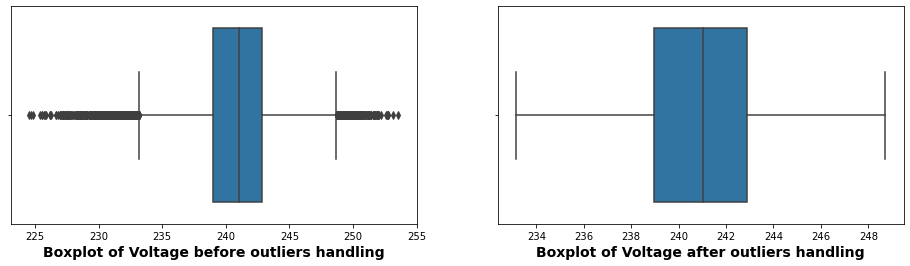

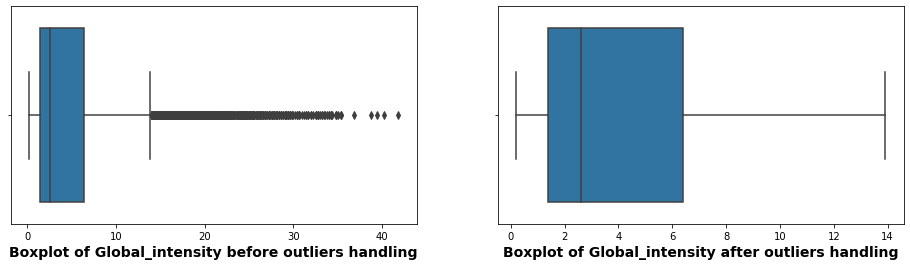

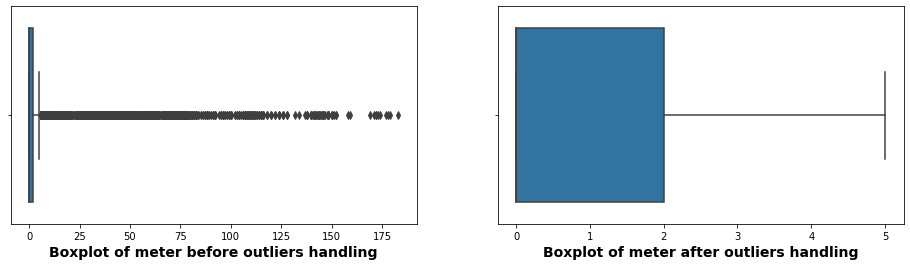

In [29]:
#compare the distribution across quantile

for col in df1.columns:
    
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    sns.boxplot(df_sample[col])
    plt.xlabel(f"Boxplot of {col} before outliers handling", fontsize=14, fontweight='bold')
    
    plt.subplot(122)
    sns.boxplot(df1[col])
    plt.xlabel(f"Boxplot of {col} after outliers handling", fontsize=14, fontweight='bold')

## 4 <span style='color:red'>|</span> Model Building

In [30]:
x= df1.drop('meter', axis=1)
y = df1['meter']

In [31]:
x.shape,y.shape

((58951, 4), (58951,))

#### 4.1 <span style='color:red'>|</span> Train Test Split Dataset

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size=0.20)

#### 4.1 <span style='color:red'>|</span> Standardization

In [33]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

#### 4.3 <span style='color:red'>|</span> Modeling

In [34]:
report = []

In [35]:
models = {
    "Linear Regression" : LinearRegression(),
    "Ridge Regression" : Ridge(),
    "Lasso Regression" : Lasso(),
    "Support Vector Regression" : SVR(),
    "Decision Tree Regressor" : DecisionTreeRegressor(),
    "Random Forest Regressor" : RandomForestRegressor()
}


In [36]:
for i in range(len(models)):
    model = list(models.values())[i] 
    model.fit(x_train,y_train)
    
    #prediction
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    #Training data performance
    n = len(y_train)
    k = x_train.shape[1]
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_adj_r2 = 1-(((1-train_r2)*(n-1))/(n-k-1))
    
    #Test data performance
    n2 = len(y_test)
    k2 = x_test.shape[1]
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_adj_r2 = 1-(((1-test_r2)*(n2-1))/(n2-k2-1))
    
    report.append({"Model": list(models.keys())[i],
                 "Train MSE" : train_mse,
                 "Test MSE" : test_mse,
                 "Train MAE" : train_mae,
                 "Test MAE" : test_mae,
                 "Train R2" : train_r2,
                 "Test R2" : test_r2,
                 "Train Adj R2" : train_adj_r2,
                 "Test Adj R2" : test_adj_r2})

In [37]:
all_models = pd.DataFrame(report)
all_models

,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R2,Test R2,Train Adj R2,Test Adj R2
0,Linear Regression,1.970973,1.953971,1.067391,1.062534,0.260330,0.264920,0.260268,0.264671
1,Ridge Regression,1.970979,1.954024,1.067370,1.062533,0.260328,0.264900,0.260265,0.264651
2,Lasso Regression,2.664667,2.658216,1.364178,1.363033,0.000000,-0.000015,-0.000085,-0.000354
3,Support Vector Regression,2.084567,2.137699,0.844698,0.856770,0.217701,0.195802,0.217634,0.195529
4,Decision Tree Regressor,0.016069,3.457748,0.007487,1.091054,0.993970,-0.300797,0.993969,-0.301239
5,Random Forest Regressor,0.277769,1.926532,0.359164,0.974868,0.895758,0.275243,0.895750,0.274997


#### 4.4 <span style='color:red'>|</span> Hyperparameter Tunning

In [42]:
rf_record = []

In [38]:
ran_params = {'max_depth':[5,8,10,15,None],
              'max_features':[3,'auto'],
              'min_samples_split':[2,8,15,20],
              'n_estimators':[50,100,200,500]}

In [39]:
random = RandomizedSearchCV(estimator=RandomForestRegressor(),
                           param_distributions=ran_params,
                           n_iter=100,
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

In [40]:
random.fit(x_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 15, None],
                                        'max_features': [3, 'auto'],
                                        'min_samples_split': [2, 8, 15, 20],
                                        'n_estimators': [50, 100, 200, 500]},
                   verbose=2)

In [41]:
random.best_params_, random.best_estimator_

({'n_estimators': 500,
  'min_samples_split': 20,
  'max_features': 3,
  'max_depth': 15},
 RandomForestRegressor(max_depth=15, max_features=3, min_samples_split=20,
                       n_estimators=500))

In [48]:
rf_best = RandomForestRegressor(max_depth=15, max_features=3, min_samples_split=20, n_estimators=500)
rf_best.fit(x_train, y_train)

#prefiction
rf_pred_train = rf_best.predict(x_train)
rf_pred_test = rf_best.predict(x_test)

#training data performance
rf_train_mse = mean_squared_error(y_train, rf_pred_train)
rf_train_mae = mean_absolute_error(y_train, rf_pred_train)
rf_train_r2 = r2_score(y_train, rf_pred_train)
rf_train_adj_r2 = 1-(((1-rf_train_r2)*(len(y_train)-1))/(len(y_train)-(x_train.shape[1])-1))

# #testing data performance
rf_test_mse = mean_squared_error(y_test, rf_pred_test)
rf_test_mae = mean_absolute_error(y_test, rf_pred_test)
rf_test_r2 = r2_score(y_train, rf_pred_train)
rf_test_adj_r2 = 1-(((1-rf_test_r2)*(len(y_test)-1))/(len(y_test)-(x_test.shape[1])-1))

In [49]:
rf_record.append({'Model':'Hyperparamter tunned RF',
                 'Train_mse':rf_train_mse,
                 'Train_mae':rf_train_mae,
                 'Train_r2': rf_train_r2,
                 'Train_ad_r2':rf_train_adj_r2,
                 'Test_mse':rf_test_mse,
                 'Test_mae':rf_test_mae,
                 'Test_r2':rf_test_r2,
                 'Test_ad_r2':rf_test_adj_r2})
hyp_model = pd.DataFrame(rf_record)
hyp_model

,Model,Train_mse,Train_mae,Train_r2,Train_ad_r2,Test_mse,Test_mae,Test_r2,Test_ad_r2
0,Hyperparamter tunned RF,1.357387,0.846047,0.490598,0.490555,1.768069,0.960408,0.490598,0.490425
